# Predicting profit for 50 startups

We have 50 start-ups.  
For each one we know: R&D spend, admin spend, marketing spend, state, category.  
We want a single number: the profit we can expect.

#### _Var_:  
**ID** - startup ID  
**R&D Spend** - how much each startup spends on Research and Development  
**Administration** - how much they spend on Administration cost  
**Marketing Spend** - how much they spend on Marketing  
**State** - which state the startup is based in  
**Category** - which business category the startup belong to  
**Profit** - the profit made by the startup  

## Import, Load

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
from scipy import stats                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

from sklearn import metrics, linear_model, model_selection
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

In [61]:
train = pd.read_csv("train.csv")
final_test = pd.read_csv("test.csv")

target = train['Profit']

## Exploratory Data Analysis (EDA)

Check data types, missing values, and summaries next to identify cleaning needs.  
Then, visualize distributions and relationships to understand patterns.

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               50 non-null     int64  
 1   R&D Spend        48 non-null     float64
 2   Administration   50 non-null     float64
 3   Marketing Spend  47 non-null     float64
 4   State            50 non-null     object 
 5   Category         49 non-null     object 
 6   Profit           50 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 2.9+ KB


In [63]:
final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               50 non-null     int64  
 1   R&D Spend        48 non-null     float64
 2   Administration   48 non-null     float64
 3   Marketing Spend  50 non-null     float64
 4   State            49 non-null     object 
 5   Category         50 non-null     object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.5+ KB


In [64]:
train.head()

,ID,R&D Spend,Administration,Marketing Spend,State,Category,Profit
0,0,165349.20,136897.80,471784.10,New York,Industrials,192261.83
1,1,162597.70,151377.59,443898.53,California,Technology,191792.06
2,2,153441.51,101145.55,407934.54,Florida,Healthcare,191050.39
3,3,144372.41,118671.85,383199.62,New York,Financials,182901.99
4,4,142107.34,91391.77,366168.42,Florida,Industrials,166187.94


In [65]:
final_test.head()

,ID,R&D Spend,Administration,Marketing Spend,State,Category
0,0,165349.20,136897.80,471784.10,New York,Industrials
1,1,162597.70,151377.59,443898.53,California,Technology
2,2,153441.51,101145.55,407934.54,Florida,Healthcare
3,3,144372.41,118671.85,383199.62,New York,Financials
4,4,142107.34,91391.77,366168.42,Florida,Industrials


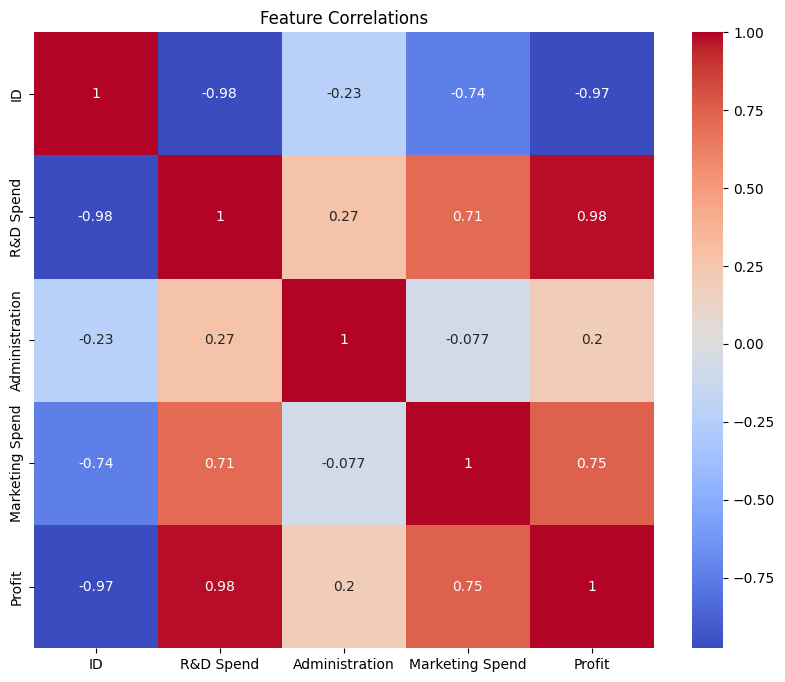

In [ ]:
# Add correlation heatmap next to show feature relationships.
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

The dataset consists of 50 entries with no missing values.  
The target variable is 'Profit'.  
The features include numerical financial data (R&D, Administration, Marketing) and categorical location/industry data ('State', 'Category').  
Given the small sample size (50 rows), we must be cautious of overfitting when applying complex models later in the process.

In [ ]:
train['Profit'].describe()

count        50.000000
mean     112012.639200
std       40306.180338
min       14681.400000
25%       90138.902500
50%      107978.190000
75%      139765.977500
max      192261.830000
Name: Profit, dtype: float64

<Axes: xlabel='Profit', ylabel='Count'>

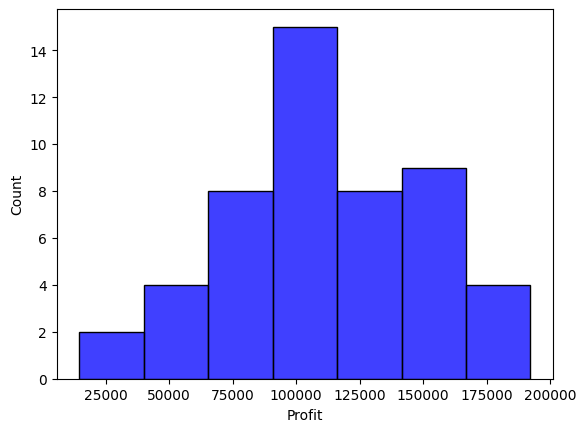

In [8]:
# visualisation of 'Profit' distribution
sns.histplot(train['Profit'], color='b')

In [ ]:
train = train.set_index('ID')
final_test = final_test.set_index('ID')

In [ ]:
numerical_feats_train = train.dtypes[train.dtypes != 'object'].index
print ('Quantity of Numerical features: ', len(numerical_feats_train))
print ()
print (train[numerical_feats_train].columns)
print ()
categorical_feats_train = train.dtypes[train.dtypes == 'object'].index
print ('Quantity of Categorical features: ', len(categorical_feats_train))
print ()
print (train[categorical_feats_train].columns)

Quantity of Numerical features:  4

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'Profit'], dtype='object')

Quantity of Categorical features:  2

Index(['State', 'Category'], dtype='object')


In [11]:
train.Category.value_counts()


Category
Technology            22
Healthcare            11
Financials             6
Industrials            5
Telecommunications     4
Oil & Gas              1
Name: count, dtype: int64

## Missing values, Preprocessing

In [12]:
# check the Train features with missing values 
nan_columns = [i for i in train.columns if train[i].isnull().any()]
print(train.isnull().sum())
print()
print("There are " + str(len(nan_columns)) +" columns with NAN values for 50 rows.")
nan_columns

R&D Spend          2
Administration     0
Marketing Spend    3
State              0
Category           1
Profit             0
dtype: int64

There are 3 columns with NAN values for 50 rows.


['R&D Spend', 'Marketing Spend', 'Category']

In [13]:
# check the Test features with missing values
nan_columns_final = [i for i in final_test.columns if final_test[i].isnull().any()]
print(final_test.isnull().sum())
print()
print("There are " + str(len(nan_columns_final)) +" columns with NAN values for 50 rows.")
nan_columns.append('Marketing Spend')  # adding 'Marketing Spend' from Test set
nan_columns

R&D Spend          2
Administration     2
Marketing Spend    0
State              1
Category           0
dtype: int64

There are 3 columns with NAN values for 50 rows.


['R&D Spend', 'Marketing Spend', 'Category', 'Marketing Spend']

Explaining in further depth:

* 'R&D Spend': Numerical - replacement of NAN by 'mean';
* 'Administration': Numerical - replacement of NAN by 'mean';
* 'Marketing Spend': Numerical - replacement of NAN by 'mean';
* 'State': Categorical - replacement of NAN by 'None';
* 'Category': Categorical - replacement of NAN by 'None'.

In [14]:
nan_columns_fill = [
    'State', 
    'Category'
    ]
for col in nan_columns_fill:
    if train[col].dtype == 'object':  # или np.object_
        train.fillna({col: 'None'}, inplace=True)
        final_test.fillna({col: 'None'}, inplace=True)
    else:
        print(f'Внимание: {col} не строковый, а {train[col].dtype}')



In [ ]:
for col in ['R&D Spend', 'Administration', 'Marketing Spend']:
    mean_value = train[col].mean()
    train.loc[:, col] = train[col].fillna(mean_value)
    final_test[col] = final_test[col].fillna(mean_value)

In [16]:
# check is there any mising values left in Train
train.isnull().sum().sum()

np.int64(0)

In [17]:
final_test.shape

(50, 5)

In [18]:
final_test.head()

,R&D Spend,Administration,Marketing Spend,State,Category
ID,,,,,
0,165349.20,136897.80,471784.10,New York,Industrials
1,162597.70,151377.59,443898.53,California,Technology
2,153441.51,101145.55,407934.54,Florida,Healthcare
3,144372.41,118671.85,383199.62,New York,Financials
4,142107.34,91391.77,366168.42,Florida,Industrials


In [19]:
final_test.isnull().sum().sum()

np.int64(0)

Data preprocessing: removed the unique 'ID' identifier as it holds no predictive value.  
Categorical variables ('State', 'Category') were encoded using One-Hot Encoding (pd.get_dummies) to convert them into a numerical format suitable for regression models.  
This expands the feature space slightly but allows the model to interpret geographic and categorical differences.

### Visualisation  of Numerical features (regplot)

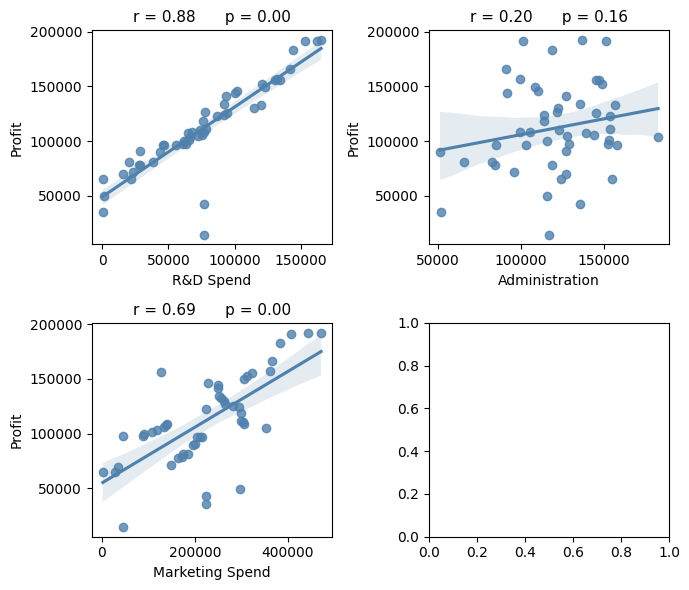

In [20]:
# numerical features visualisation
nr_rows = 2
nr_cols = 2

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

num_feats = list(numerical_feats_train)
not_plot = ['Id',  'Profit']
plot_num_feats = [c for c in list(numerical_feats_train) if c not in not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols + c
        if i < len(plot_num_feats):
            sns.regplot(x=train[plot_num_feats[i]], y=train['Profit'], ax = axs[r][c], color = "#5081ac" )
            stp = stats.pearsonr(train[plot_num_feats[i]], train['Profit'])
          
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title, fontsize=11)



plt.tight_layout()    
plt.show()

Exploratory Data Analysis reveals strong positive correlations between 'Profit' and 'R&D Spend' (0.97), as well as 'Marketing Spend'.  
Conversely, 'Administration' costs show little to no linear relationship with the target.  
This suggests that investment in product development and marketing are the primary drivers of profitability in this dataset, while administrative overhead is less predictive.

C:\Users\mamon\AppData\Local\Temp\ipykernel_23512\1998211702.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'State', y = 'Profit', data = train, palette = "Blues_d", legend=False)


<Axes: xlabel='State', ylabel='Profit'>

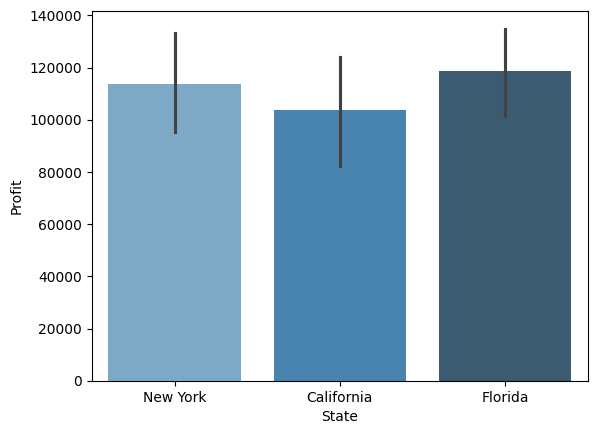

In [21]:
# profit split in State level
sns.barplot(x = 'State', y = 'Profit', data = train, palette = "Blues_d", legend=False)

In [ ]:
# profit split in State level
sns.barplot(x = 'Category', y = 'Profit', data = train, palette = "Blues_d")
plt.xticks(rotation=90)

## One-Hot Encoding

In [23]:
# One-Hot Encoding Train dataset

train = pd.get_dummies(train,columns=['State', 'Category'])
target = train['Profit']

# Drop target variable 
train = train.drop(columns=['Profit'])


In [24]:
# preview of the first 5 lines of the loaded Train data 
train.head()

,R&D Spend,Administration,Marketing Spend,State_California,State_Florida,State_New York,Category_Financials,Category_Healthcare,Category_Industrials,Category_None,Category_Oil & Gas,Category_Technology,Category_Telecommunications
ID,,,,,,,,,,,,,
0,165349.20,136897.80,471784.10,False,False,True,False,False,True,False,False,False,False
1,162597.70,151377.59,443898.53,True,False,False,False,False,False,False,False,True,False
2,153441.51,101145.55,407934.54,False,True,False,False,True,False,False,False,False,False
3,144372.41,118671.85,383199.62,False,False,True,True,False,False,False,False,False,False
4,142107.34,91391.77,366168.42,False,True,False,False,False,True,False,False,False,False


In [25]:
# Drop unnecessary variables 
train = train.drop(columns=['Category_None'])

In [27]:
# One-Hot Encoding Test dataset
final_test = pd.get_dummies(final_test,columns=['State', 'Category'])
final_test.head()

,R&D Spend,Administration,Marketing Spend,State_California,State_Florida,State_New York,State_None,Category_Financials,Category_Healthcare,Category_Industrials,Category_Oil & Gas,Category_Technology,Category_Telecommunications
ID,,,,,,,,,,,,,
0,165349.20,136897.80,471784.10,False,False,True,False,False,False,True,False,False,False
1,162597.70,151377.59,443898.53,True,False,False,False,False,False,False,False,True,False
2,153441.51,101145.55,407934.54,False,True,False,False,False,True,False,False,False,False
3,144372.41,118671.85,383199.62,False,False,True,False,True,False,False,False,False,False
4,142107.34,91391.77,366168.42,False,True,False,False,False,False,True,False,False,False


In [28]:
final_test = final_test.drop(columns=['State_None'])

## 'Train\Test' split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.30, random_state=27)

In [32]:
X_train.shape

(35, 12)

## StandardScaler

In [ ]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)
final_test_scaled = scaler.transform(final_test)


## Two models - LR and GB

In [ ]:
LR = LinearRegression()

LR.fit(train_scaled,y_train)

LR_pred = LR.predict(test_scaled)
LR_pred

array([149508.7717395 , 110626.18460399,  85790.61221051,  54518.96923537,
       140508.88970539, 146347.9852258 , 121193.65975156, 120442.20778232,
       104208.28704842,  79079.18228512, 117953.93847876,  46200.16756101,
       180478.91354496, 132438.30551055, 128857.5093249 ])

In [ ]:
LRscore = LR.score(test_scaled, y_test)
LRscore

0.8139762119179693

In [36]:
# Model Metrics
LRMetrics = pd.DataFrame({'Model': 'Linear Regression',
                          'r2score':r2_score(y_test,LR_pred),
                          'MAE': metrics.mean_absolute_error (y_test,LR_pred),
                          'MSE': metrics.mean_squared_error(y_test,LR_pred),
                          'RMSE': np.sqrt(metrics.mean_squared_error(y_test,LR_pred)),
                          'MSLE': metrics.mean_squared_log_error(y_test,LR_pred),
                          'RMSLE':np.sqrt(metrics.mean_squared_log_error(y_test,LR_pred))             
                          },index=[1])

LRMetrics

,Model,r2score,MAE,MSE,RMSE,MSLE,RMSLE
1,Linear Regression,0.813976,12969.221515,2.544529e+08,15951.579675,0.039393,0.198477


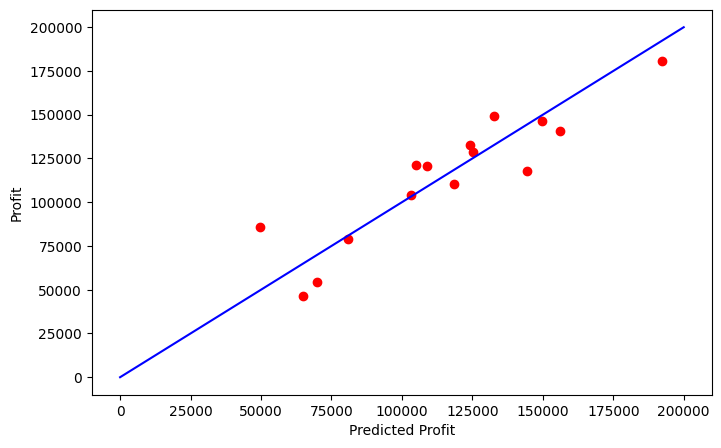

In [37]:
# visualisation of Train dataset predictions

# Plot outputs
plt.figure(figsize=(8,5))
pl.plot(y_test, LR_pred,'ro')
pl.plot([0,200000],[0,200000],'b-')
pl.xlabel('Predicted Profit')
pl.ylabel('Profit')
pl.show()

In [38]:
# Test final predictions
y = target

LR_pred1 = LR.predict(final_test_scaled)
LR_pred1  

array([180478.91354496, 182606.67937728, 187926.70717867, 175348.05546874,
       157392.26904827, 165667.00046425, 140508.88970539, 162081.75397085,
       155051.21097133, 146347.9852258 , 139069.63340229, 117953.93847876,
       130081.95602055, 106082.95287912, 149508.7717395 , 136455.87038316,
       116581.11643598, 128857.5093249 , 132438.30551055, 120992.83655161,
       110626.18460399, 129582.66537406, 130355.84193925, 117981.9737381 ,
       105108.9141514 ,  98393.66762926, 107816.08337581, 121193.65975156,
        97511.69918306, 100700.74272122,  99183.95064914,  76815.36081722,
        76726.69155787, 100557.94356218,  97047.59190649,  85023.95136074,
        85131.73668745,  80703.72701003,  72224.94410004,  79079.18228512,
        87971.50052212,  83460.81750654,  67421.32344233,  54518.96923537,
        52245.17922793,  46200.16756101,  85790.61221051,  99525.0463292 ,
        41168.1693428 ,  72369.66725538])

In [ ]:
LRMetrics1 = pd.DataFrame({'Model': 'Linear Regression',
                           'r2score':r2_score(y,LR_pred1),
                           'MAE': metrics.mean_absolute_error (y,LR_pred1),
                           'MSE': metrics.mean_squared_error(y,LR_pred1),
                           'RMSE': np.sqrt(metrics.mean_squared_error(y,LR_pred1)),
                           'MSLE': metrics.mean_squared_log_error(y,LR_pred1),
                           'RMSLE':np.sqrt(metrics.mean_squared_log_error(y,LR_pred1))             
                           },index=[1])

LRMetrics1

,Model,r2score,MAE,MSE,RMSE,MSLE,RMSLE
1,Linear Regression,0.821267,11922.940193,2.845601e+08,16868.908111,0.085131,0.291771


The Linear Regression baseline performs reasonably well, explaining a significant portion of the variance ($R^2 \approx 0.82$ on test data).

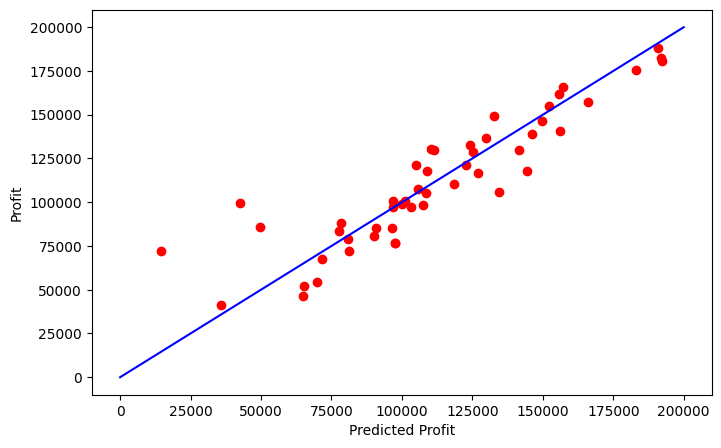

In [40]:
# visualisation of Test dataset predictions

# Plot outputs
plt.figure(figsize=(8,5))
pl.plot(y, LR_pred1,'ro')
pl.plot([0,200000],[0,200000],'b-')
pl.xlabel('Predicted Profit')
pl.ylabel('Profit')
pl.show()

In [41]:
# comparison between Actual 'Profit' from Train dataset abd Predicted 'Profit' from Test dataset
actualvspredicted = pd.DataFrame({"Actual Profit":y,"LR Predicted Profit":LR_pred1 })
actualvspredicted.head(10).style.background_gradient(cmap='Blues')

,Actual Profit,LR Predicted Profit
ID,,
0,192261.830000,180478.913545
1,191792.060000,182606.679377
2,191050.390000,187926.707179
3,182901.990000,175348.055469
4,166187.940000,157392.269048
5,156991.120000,165667.000464
6,156122.510000,140508.889705
7,155752.600000,162081.753971
8,152211.770000,155051.210971


### **Gradient Boosting Regressor**

In [ ]:
GB=GradientBoostingRegressor(random_state=27)

GB.fit(train_scaled,y_train)

GB_pred = GB.predict(test_scaled)

GBscore =GB.score(test_scaled, y_test)
GBscore

0.7936284220428356

In [ ]:
GBMetrics = pd.DataFrame({'Model': 'Gradient Boosting Regressor',
                          'r2score':r2_score(y_test,GB_pred),
                          'MAE': metrics.mean_absolute_error (y_test,GB_pred),
                          'MSE': metrics.mean_squared_error(y_test,GB_pred),
                          'RMSE': np.sqrt(metrics.mean_squared_error(y_test,GB_pred)),
                          'MSLE': metrics.mean_squared_log_error(y_test,GB_pred),
                          'RMSLE':np.sqrt(metrics.mean_squared_log_error(y_test,GB_pred))             
                          },index=[2])

GBMetrics

,Model,r2score,MAE,MSE,RMSE,MSLE,RMSLE
2,Gradient Boosting Regressor,0.793628,11007.154299,2.822856e+08,16801.358471,0.042612,0.206427


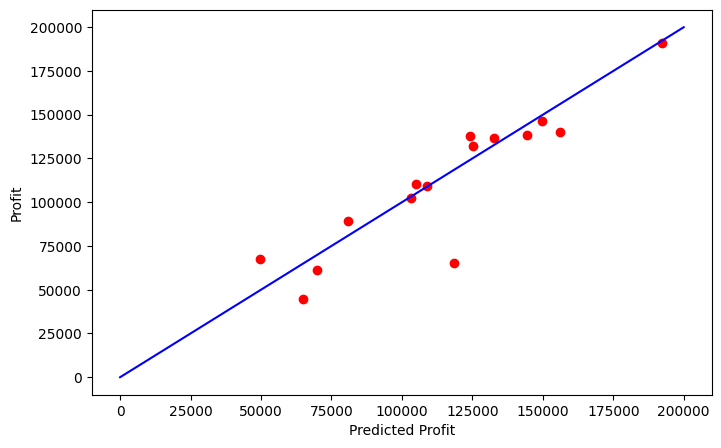

In [45]:
# visualisation of Test dataset predictions

# Plot outputs
plt.figure(figsize=(8,5))
pl.plot(y_test, GB_pred,'ro')
pl.plot([0,200000],[0,200000], 'b-')
pl.xlabel('Predicted Profit')
pl.ylabel('Profit')
pl.show()

In [ ]:
GB_pred1 = GB.predict(final_test_scaled)

In [ ]:
GBMetrics1 = pd.DataFrame({'Model': 'GradientBoostingRegressor',
                           'r2score':r2_score(y,GB_pred1),
                           'MAE': metrics.mean_absolute_error (y,GB_pred1),
                           'MSE': metrics.mean_squared_error(y,GB_pred1),
                           'RMSE': np.sqrt(metrics.mean_squared_error(y,GB_pred1)),
                           'MSLE': metrics.mean_squared_log_error(y,GB_pred1),
                           'RMSLE':np.sqrt(metrics.mean_squared_log_error(y,GB_pred1))             
                          },index=[1])

GBMetrics1

,Model,r2score,MAE,MSE,RMSE,MSLE,RMSLE
1,GradientBoostingRegressor,0.939709,4342.85575,9.598944e+07,9797.420054,0.016264,0.127532


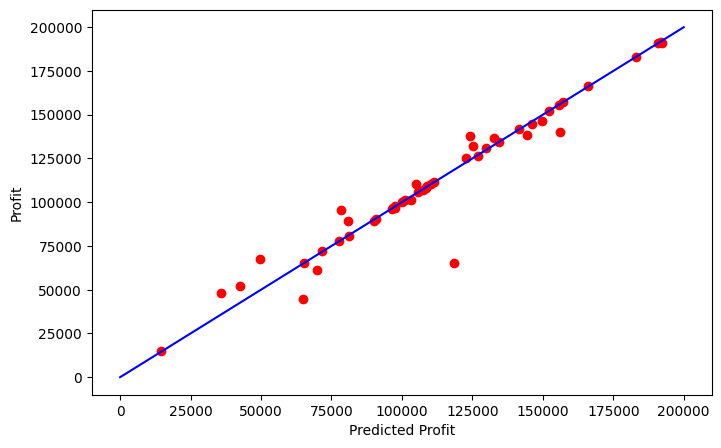

In [48]:
# visualisation of Test dataset predictions

# Plot outputs
plt.figure(figsize=(8,5))
pl.plot(y, GB_pred1,'ro')
pl.plot([0,200000],[0,200000], 'b-')
pl.xlabel('Predicted Profit')
pl.ylabel('Profit')
pl.show()

## Model comparison

In [49]:
# score comparison of models
frames = [LRMetrics1,GBMetrics1]
TrainingResult = pd.concat(frames)
TrainingResult

,Model,r2score,MAE,MSE,RMSE,MSLE,RMSLE
1,Linear Regression,0.821267,11922.940193,2.845601e+08,16868.908111,0.085131,0.291771
1,GradientBoostingRegressor,0.939709,4342.855750,9.598944e+07,9797.420054,0.016264,0.127532


In [50]:
# comparison between Actual 'Profit' from Train dataset abd Predicted 'Profit' from Test dataset
actualvspredicted = pd.DataFrame({"Actual Profit":y,"LR Predicted Profit":LR_pred1, "GB Predicted Profit":GB_pred1})
actualvspredicted.head(20).style.background_gradient(cmap='Blues')

,Actual Profit,LR Predicted Profit,GB Predicted Profit
ID,,,
0,192261.830000,180478.913545,190752.823988
1,191792.060000,182606.679377,191482.244809
2,191050.390000,187926.707179,191046.988160
3,182901.990000,175348.055469,182750.066794
4,166187.940000,157392.269048,166219.175865
5,156991.120000,165667.000464,157001.814461
6,156122.510000,140508.889705,140384.460429
7,155752.600000,162081.753971,155772.123117
8,152211.770000,155051.210971,152126.641667


**Result**: The best model is **Gradient Boosting Regressor** with **R2 score = 0.9397**.  
To capture potential non-linear relationships and reduce bias, we applied a Gradient Boosting Regressor.  
This ensemble method builds trees sequentially to correct previous errors.  
The initial results show a substantial improvement over the linear baseline.

In [51]:
fuature_importance = GB.feature_importances_ 
fuature_names = train.columns
joined = pd.DataFrame({'Feature': fuature_names, 'Importance': fuature_importance})
joined.sort_values(by='Importance', ascending=False)


,Feature,Importance
0,R&D Spend,0.714163
2,Marketing Spend,0.259003
1,Administration,0.013495
3,State_California,0.004960
10,Category_Technology,0.003996
5,State_New York,0.001897
4,State_Florida,0.001789
11,Category_Telecommunications,0.000301
8,Category_Industrials,0.000241
7,Category_Healthcare,0.000155


##  Save results:

In [ ]:
sub = pd.DataFrame()
sub['ID'] = final_test.index
sub['Profit'] = GB_pred1
sub.to_csv('StartupPredictions.csv', index=False)

Feature Selection Experiment: Based on the initial correlation matrix, the 'Administration' feature had a weak relationship with Profit.  
We hypothesize that this feature might be acting as noise. We will now retrain the Gradient Boosting model on a reduced feature set (excluding Administration) to observe if model efficiency or accuracy improves by focusing only on high-impact variables.

In [53]:
train_cut=pd.read_csv("train.csv")
train_cut=train_cut[['R&D Spend','Marketing Spend','Profit']]
train_cut.head()
y_cut=train_cut['Profit']
X_cut=train_cut.drop(columns=['Profit'])

nan_columns_cut = [i for i in X_cut.columns if X_cut[i].isnull().any()]
print(X_cut.isnull().sum())
print()
print("There are " + str(len(nan_columns_cut)) +" columns with NAN values for 50 rows.")
nan_columns_cut 



R&D Spend          2
Marketing Spend    3
dtype: int64

There are 2 columns with NAN values for 50 rows.


['R&D Spend', 'Marketing Spend']

In [ ]:
for col in nan_columns_cut:
    mean_value_cut = X_cut[col].mean()
    X_cut.loc[:, col] = X_cut[col].fillna(mean_value_cut)

In [55]:
X_cut.isna().sum()

R&D Spend          0
Marketing Spend    0
dtype: int64

In [ ]:
X_cut_train, X_cut_test, y_cut_train, y_cut_test = train_test_split(X_cut, y_cut, test_size=0.30, random_state=27)

sc2=StandardScaler()
train_cut_scaled = sc2.fit_transform(X_cut_train)
test_cut_scaled = sc2.transform(X_cut_test)

GB2=GradientBoostingRegressor(random_state=27)
GB2.fit(train_cut_scaled, y_cut_train)
GB2_pred = GB2.predict(test_cut_scaled)

GB2Metrics = pd.DataFrame({'Model': 'Gradient Boosting Regressor (cutted)',
                          'r2score':r2_score(y_cut_test,GB2_pred),
                            'MAE': metrics.mean_absolute_error (y_cut_test,GB2_pred),
                            'MSE': metrics.mean_squared_error(y_cut_test,GB2_pred),
                            'RMSE': np.sqrt(metrics.mean_squared_error(y_cut_test,GB2_pred)),
                            'MSLE': metrics.mean_squared_log_error(y_cut_test,GB2_pred),
                            'RMSLE':np.sqrt(metrics.mean_squared_log_error(y_cut_test,GB2_pred))             
                          },index=[3])
GB2Metrics

,Model,r2score,MAE,MSE,RMSE,MSLE,RMSLE
3,Gradient Boosting Regressor (cutted),0.791881,9893.028738,2.846753e+08,16872.323752,0.038978,0.197427


In [57]:

frames2 = [TrainingResult,GB2Metrics]   
comparison_df = pd.concat(frames2)
comparison_df

,Model,r2score,MAE,MSE,RMSE,MSLE,RMSLE
1,Linear Regression,0.821267,11922.940193,2.845601e+08,16868.908111,0.085131,0.291771
1,GradientBoostingRegressor,0.939709,4342.855750,9.598944e+07,9797.420054,0.016264,0.127532
3,Gradient Boosting Regressor (cutted),0.791881,9893.028738,2.846753e+08,16872.323752,0.038978,0.197427


In [58]:
gb2_pred1 = GB2.predict(sc2.transform(final_test[['R&D Spend','Marketing Spend']]))
gb2_metrics_final = pd.DataFrame({'Model': 'Gradient Boosting Regressor (cutted)',
                          'r2score':r2_score(y,gb2_pred1),
                            'MAE': metrics.mean_absolute_error (y,gb2_pred1),
                            'MSE': metrics.mean_squared_error(y,gb2_pred1),
                            'RMSE': np.sqrt(metrics.mean_squared_error(y,gb2_pred1)),
                            'MSLE': metrics.mean_squared_log_error(y,gb2_pred1),
                            'RMSLE':np.sqrt(metrics.mean_squared_log_error(y,gb2_pred1))
                            },index=[1])
gb2_metrics_final

,Model,r2score,MAE,MSE,RMSE,MSLE,RMSLE
1,Gradient Boosting Regressor (cutted),0.936868,4282.304667,1.005125e+08,10025.590094,0.016686,0.129174


# Project Conclusion

Model Performance: The Gradient Boosting Regressor (using all features) yielded the best results, achieving the lowest RMSE and highest $R^2$ score (~0.94), significantly outperforming the Linear Regression baseline.  

Feature Impact: Removing 'Administration' did not drastically improve the model, suggesting the tree-based model was already effectively handling the low-importance feature.  

Business Insight: The analysis confirms that R&D Spend is the most critical predictor of startup success.  
Investors looking to maximize profit should prioritize companies with high R&D and Marketing budgets, regardless of their Administrative costs or State location.


## What else we can do?

Check multicoleniarity  
P-value  
t-test



Tune hyperparameters for better scores.  
Add cross-validation for robustness.